# 1. Data preparation

Debug enabled in datasets.py
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded spots...
Aligning (5, 41, 31, 31) psfs...


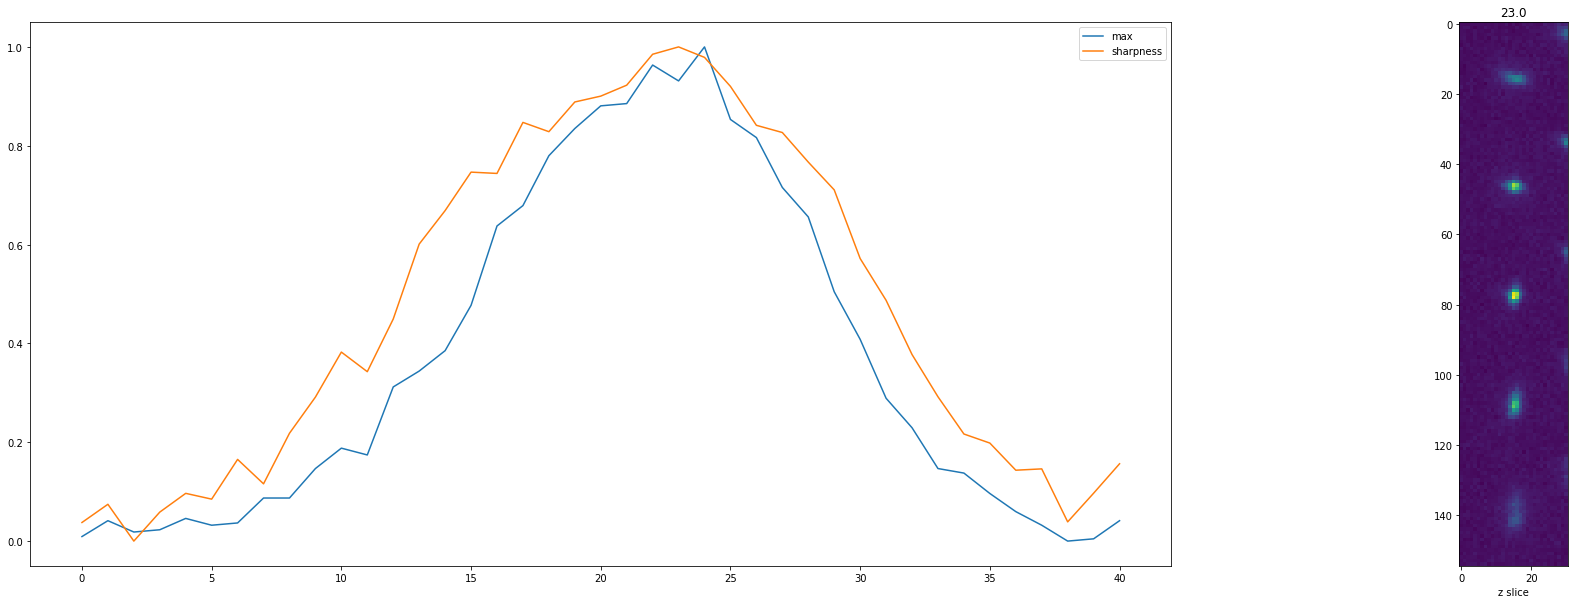

100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


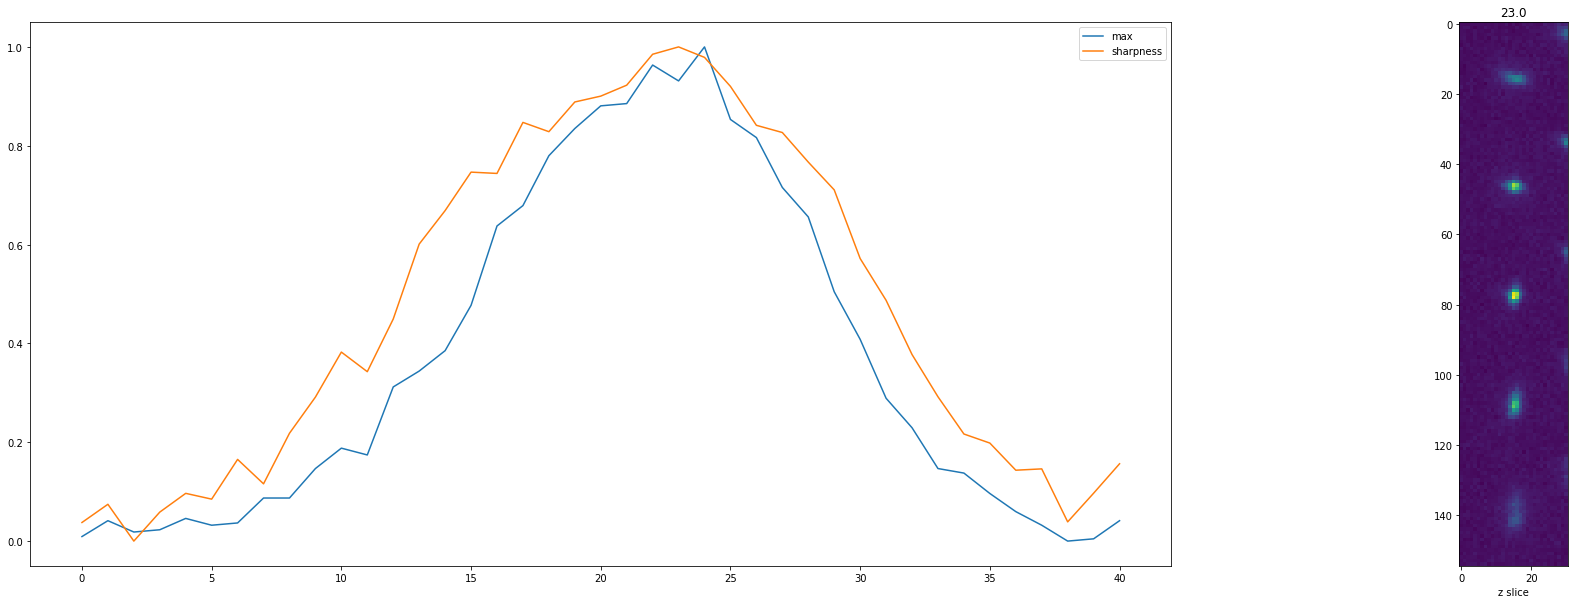

1150.0 3150.0 1150.0
-1150.0 850.0 23.0
1065.0 3065.0 1150.0
-1235.0 765.0 23.0
1095.0 3095.0 1150.0
-1205.0 795.0 23.0
1075.0 3075.0 1150.0
-1225.0 775.0 23.0
1090.0 3090.0 1150.0
-1210.0 790.0 23.0
Prepared stacks...
masking
Adding noise... 15


In [19]:
%load_ext autoreload
%autoreload 2

from data.datasets import TrainingPicassoDataset
from config.datasets import dataset_configs

z_range = 1000
dataset = 'picasso_test'
train_dataset = TrainingPicassoDataset(dataset_configs[dataset]['training'], z_range)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]


In [22]:
for k, v in train_dataset.data.items():
    print(k, v[1].min(), v[1].max())

train -1035.0 850.0
val -955.0 800.0
test -1050.0 715.0


In [21]:

from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np
import tensorflow as tf
for k in train_dataset.data.keys():
    train_dataset.data[k][0] = train_dataset.data[k][0][0]
    train_dataset.data[k][0] = np.stack([tf.image.grayscale_to_rgb(tf.convert_to_tensor(img)).numpy() for img in train_dataset.data[k][0]])

    train_dataset.data[k][0] = np.stack([resize(img, (32, 32, 3), anti_aliasing=True) for img in train_dataset.data[k][0]])
    train_dataset.data[k][0] = tf.keras.applications.resnet50.preprocess_input(train_dataset.data[k][0])

# 2. Training the model

Currently, I'm using 2 'calibration' datasets to see if my model can adapt from one to the other.
All of the training dataset is used for training, and the 2nd dataset is used as validation.

In [3]:
TRAIN_NEW_MODEL = True

In [4]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import Sequential
import tensorflow as tf

model = Sequential([
    tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=None,
        pooling='avg',
        classes=1,
        classifier_activation="linear",
    ),
    Dense(1024),
    Dropout(0.5),
    Dense(1024),
    Dropout(0.5),
    Dense(1)
])
print(model.summary())

from tensorflow import keras
lr=0.001
model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr, decay=1e-6),metrics=['mean_absolute_error'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 26,713,601
Trainable params: 26,668,161
No

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



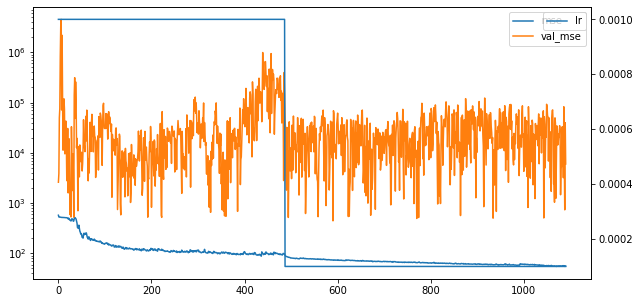

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 26,713,601
Trainable params: 26,668,161
No

In [5]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from model.model import load_new_model, save_model, load_trained_model
import numpy as np
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
import tensorflow as tf

import os
import logging

bound = train_dataset.data['train'][0][0].shape[1]

BATCH_SIZE = 2**8
LEARNING_RATE = 1e-3

import glob

def train_model(dataset, val_dataset=None, pretrained_model=None):
    if not val_dataset:
        val_dataset = dataset['val']
#     for k in dataset:
#         imgs = dataset[k][0][0]
#         norm_imgs = imgs / imgs.max(axis=(1, 2))[:, np.newaxis, np.newaxis]
#         dataset[k][0][0] = norm_imgs


    callbacks = [
        ReduceLROnPlateau(
        monitor='loss', factor=0.1, patience=50, verbose=True,
        mode='min', min_delta=1, cooldown=50, min_lr=1e-7,),
#         ReduceLROnPlateau(
#         monitor='val_mean_absolute_error', factor=0.1, patience=50, verbose=True,
#         mode='min', min_delta=1, cooldown=50, min_lr=1e-10,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=500, verbose=False, min_delta=1, restore_best_weights=True),
#         WandbCallback(save_model=False),
        TqdmCallback(verbose=1),
    ]

    history = model.fit(*dataset['train'], epochs=5000, verbose=False, batch_size=BATCH_SIZE, validation_data=(*val_dataset,), callbacks=callbacks)
    
    plt.rcParams['figure.figsize'] = [10, 5]
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mse')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model

model = train_model(train_dataset.data)
print(model.summary())

1349/1349 [==============================] - 6s 4ms/step
Mean error 460.85783796258266
std error 330.86045058872725


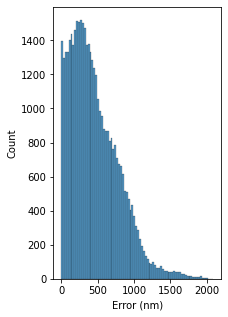

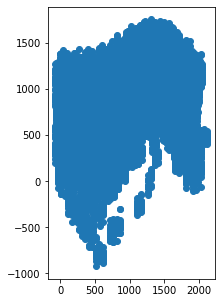

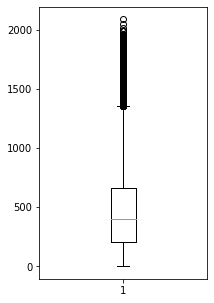

NameError: name 'test_imgs' is not defined

In [7]:
import seaborn as sns
import random

test_x, test_y = train_dataset.data['test']

# from scipy.ndimage import median_filter
# test_x[0] = np.stack([median_filter(d, size=2) for d in test_x[0].copy()])

# from final_project.smlm_3d.data.datasets import mask_img_stack
# test_x[0] = mask_img_stack(test_x[0].copy(), radius=12)


pred_y = model.predict(test_x).squeeze()
error = abs(test_y-pred_y)

print(f'Mean error {np.mean(error)}')
print(f'std error {np.std(error)}')

sns.histplot(error)
plt.xlabel('Error (nm)')
plt.show()


# 20220425_Miguel/training_20nm
# Cubic spline model
# Mean error 34.24343542454768
# std error 36.64187932722746

# Spline super-sampling model w/o plane fit
# Mean error 28.941918452166664
# std error 26.241176376179656


# Spline fit super-sampling model w/ improved image normalisation
# Mean error 28.089797139687477
# std error 24.976300570311047

# Latest results - spline fit super-sampling w/ improved image normalisation + plane-fit
# Mean error 27.546041584423875
# std error 26.033701351832462



# latest
# Mean error 72.83350251990716
# std error 130.39968131300466


def snr(img):
    return img.max() / np.median(img)
plt.rcParams['figure.figsize'] = [3, 5]
plt.scatter(test_y, pred_y)
plt.show()
error = abs(pred_y-test_y)
plt.boxplot(error)
plt.show()

plt.scatter([snr(img) for img in test_imgs], error, marker='.', alpha=0.2)
plt.xlabel('snr')
plt.ylabel('error [nm]')
plt.show()
idx = np.argsort(error)[::-1][0:1000]
test_imgs = test_x[0].squeeze()[idx]
plt.rcParams['figure.figsize'] = [30, 50]
plt.imshow(grid_psfs(test_imgs))
plt.show()